# Loan Default Risk Prediction Model 
**Author:** [Daniel (Euichan) Kim](https://danielkim.im/)


**Table of Contents**

1. [Introduction](#introduction)
2. [Data Wrangling](#data-wrangling)
    - [Import](#imports)
    - [Load Datasets](#load-datasets)
    - [Converting Categorical Variables into Quantitative Variables](#converting-categorical-variables-into-quantitative-variables)
        - ['term' from object to float](#term-from-object-to-float)
        - ['emp_length' from object to float](#emp_length-from-object-to-float)
        - ['grade' from object to float](#grade-from-object-to-float)
        - ['home_ownership'](#home_ownership)
    - [Classify Defaulted Loans](#classify-defaulted-loans)
    - [Handling Missing Values](#handling-missing-values)
3. [EDA](#eda)
    - [Default Counts](#default-counts)
    - [Feature Distributions](#feature-distributions)
    - [Correlation Analysis](#correlation-analysis)
        - [Loan Amount vs. Term](#loan-amount-vs-term)
        - [Grade vs. FICO Score](#grade-vs-fico-score)
        - [Grade vs. Term](#grade-vs-term)
        - [Default Flag vs. Grade](#default-flag-vs-grade)
4. [Modeling & Evaluation](#modeling--evaluation)
    - [Model Training - Logistic Regression](#model-training---logistic-regression)
    - [Model Evaluation](#model-evaluation)
        - [ROC Curve & AUC Score](#roc-curve--auc-score)
        - [Confusion Matrix](#confusion-matrix)
        - [Feature Coefficients](#feature-coefficients)
6. [Demo](#Demo)

## Introduction
In the lending industry, accurately assessing the likelihood of loan default is crucial for minimizing financial risk and maintaining portfolio health. This project focuses exclusively on accepted loan applications, which contain information on whether each loan was ultimately repaid or defaulted. Using this historical data, a logistic regression model is developed to predict the probability that a given loan will default. The goal is to provide a data-driven tool that can help financial institutions better understand their current portfolio risk and support informed decision-making for future lending strategies.

## Data Wrangling

### Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import joblib

### Load datasets

In [26]:
df = pd.read_csv('data/accepted_2007_to_2018Q4.csv')

/var/folders/fw/2qmt4cfx0dz96g1n864gmtmw0000gn/T/ipykernel_28536/4289167991.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


### Converting Categorical Variables into Quantitative Variables

#### 'term' from object to float
Completely replaced the existing 'term' column from dtype object to float.

In [27]:
if df['term'].dtype == 'object':
    df['term'] = pd.DataFrame({
        'term': df['term']
            .str.replace(' months', '', regex=False)
            .astype(float),
    })

#### 'emp_length' from object to float
Created a new column to keep existing data in-case needed for reference since 'emp_length' over 10 years is represented as 10 and less than 1 year as 0.


In [28]:
def convert_emp_length(x):
    if pd.isna(x):
        return np.nan
    x = x.strip()
    if x == '< 1 year':
        return 0
    elif x == '10+ years':
        return 10
    else:
        return int(x.split()[0])

df['emp_length_num'] = df['emp_length'].apply(convert_emp_length)

#### 'grade' from object to float

To facilitate numerical analysis, the categorical grade feature was mapped to a new numerical column, grade_num. A dictionary was used for this mapping, assigning each letter grade a corresponding integer. This conversion establishes an ordinal relationship where **a higher grade_num corresponds to a worse loan grade**.

In [29]:
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade_num'] = df['grade'].map(grade_mapping)

#### 'home_ownership'

In [30]:
home_ownership_dummies = pd.get_dummies(df['home_ownership'], prefix='home_ownership')
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,emp_length_num,grade_num
0,68407277,NaN,3600.00,3600.00,3600.00,36.00,13.99,123.03,C,C4,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,3.00
1,68355089,NaN,24700.00,24700.00,24700.00,36.00,11.99,820.28,C,C1,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,3.00
2,68341763,NaN,20000.00,20000.00,20000.00,60.00,10.78,432.66,B,B4,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,2.00
3,66310712,NaN,35000.00,35000.00,35000.00,60.00,14.85,829.90,C,C5,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,3.00
4,68476807,NaN,10400.00,10400.00,10400.00,60.00,22.45,289.91,F,F1,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,3.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,88985880,NaN,40000.00,40000.00,40000.00,60.00,10.49,859.56,B,B3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,9.00,2.00
2260697,88224441,NaN,24000.00,24000.00,24000.00,60.00,14.49,564.56,C,C4,...,Cash,Y,Mar-2019,ACTIVE,Mar-2019,10000.00,44.82,1.00,6.00,3.00
2260698,88215728,NaN,14000.00,14000.00,14000.00,60.00,14.49,329.33,C,C4,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,3.00
2260699,Total amount funded in policy code 1: 1465324575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Classify Defaulted Loans

In [31]:
def set_default_flag(loan_status):
    """
    Return 1 for default, 0 for non-default, or None for ambiguous statuses from the 'loan_status' column.
    """

    default_statuses = {
        'Charged Off',
        'Default',
        'Late (31-120 days)',
        'Does not meet the credit policy. Status:Charged Off'
    }

    non_default_statuses = {
        'Fully Paid',
        'Does not meet the credit policy. Status:Fully Paid'
    }

    if loan_status in default_statuses:
        return 1
    elif loan_status in non_default_statuses:
        return 0
    else:
        return None

df['default_flag'] = df['loan_status'].apply(set_default_flag)

df.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,emp_length_num,grade_num,default_flag
0,68407277,NaN,3600.00,3600.00,3600.00,36.00,13.99,123.03,C,C4,...,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,3.00,0.00
1,68355089,NaN,24700.00,24700.00,24700.00,36.00,11.99,820.28,C,C1,...,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,3.00,0.00
2,68341763,NaN,20000.00,20000.00,20000.00,60.00,10.78,432.66,B,B4,...,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,2.00,0.00
3,66310712,NaN,35000.00,35000.00,35000.00,60.00,14.85,829.90,C,C5,...,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,3.00,NaN
4,68476807,NaN,10400.00,10400.00,10400.00,60.00,22.45,289.91,F,F1,...,N,NaN,NaN,NaN,NaN,NaN,NaN,3.00,6.00,0.00
5,68426831,NaN,11950.00,11950.00,11950.00,36.00,13.44,405.18,C,C3,...,N,NaN,NaN,NaN,NaN,NaN,NaN,4.00,3.00,0.00
6,68476668,NaN,20000.00,20000.00,20000.00,36.00,9.17,637.58,B,B2,...,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,2.00,0.00
7,67275481,NaN,20000.00,20000.00,20000.00,36.00,8.49,631.26,B,B1,...,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,2.00,0.00
8,68466926,NaN,10000.00,10000.00,10000.00,36.00,6.49,306.45,A,A2,...,N,NaN,NaN,NaN,NaN,NaN,NaN,6.00,1.00,0.00
9,68616873,NaN,8000.00,8000.00,8000.00,36.00,11.48,263.74,B,B5,...,N,NaN,NaN,NaN,NaN,NaN,NaN,10.00,2.00,0.00


### Handling Missing Values

To ensure the accurate analysis, any rows that have missing values (NaN) within the key_columns will be filtered out.

In [32]:
key_columns = ['loan_amnt', 'term', 'grade_num', 'emp_length_num', 'annual_inc', 'dti', 'fico_range_high', 'fico_range_low', 'default_flag']
df.dropna(subset=key_columns, axis=0, inplace=True)

## EDA

In [33]:
# Round all pandas float values to 2 decimal places
pd.set_option('display.float_format', '{:.2f}'.format)

df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,...,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,emp_length_num,grade_num,default_flag
count,0.00,1289144.00,1289144.00,1289144.00,1289144.00,1289144.00,1289144.00,1289144.00,1289144.00,1289119.00,...,6907.00,4887.00,6907.00,6907.00,31324.00,31324.00,31324.00,1289144.00,1289144.00,1289144.00
mean,NaN,14630.18,14621.12,14592.61,41.98,13.27,443.63,77913.77,18.14,0.32,...,14.51,444.87,11500.24,194.21,5107.81,47.70,13.22,5.96,2.75,0.21
std,NaN,8766.98,8763.24,8770.28,10.38,4.78,262.95,71469.94,9.65,0.88,...,9.50,378.74,7634.29,199.90,3716.43,7.32,8.19,3.69,1.30,0.41
min,NaN,500.00,500.00,0.00,36.00,5.31,4.93,32.00,-1.00,0.00,...,0.00,1.92,55.73,0.01,44.21,0.20,0.00,0.00,1.00,0.00
25%,NaN,8000.00,8000.00,8000.00,36.00,9.75,252.40,48000.00,11.75,0.00,...,7.00,162.92,5443.94,45.09,2286.65,45.00,6.00,2.00,2.00,0.00
50%,NaN,12200.00,12175.00,12053.70,36.00,12.74,380.11,65000.00,17.53,0.00,...,16.00,338.04,9814.87,132.15,4254.50,45.00,14.00,6.00,3.00,0.00
75%,NaN,20000.00,20000.00,20000.00,36.00,16.01,588.37,92550.00,23.93,0.00,...,23.00,615.08,16027.22,283.27,6979.69,50.00,18.00,10.00,4.00,0.00
max,NaN,40000.00,40000.00,40000.00,60.00,30.99,1719.83,10999200.00,999.00,39.00,...,32.00,2679.15,39542.45,1407.86,33601.00,521.35,181.00,10.00,7.00,1.00


### Default Counts

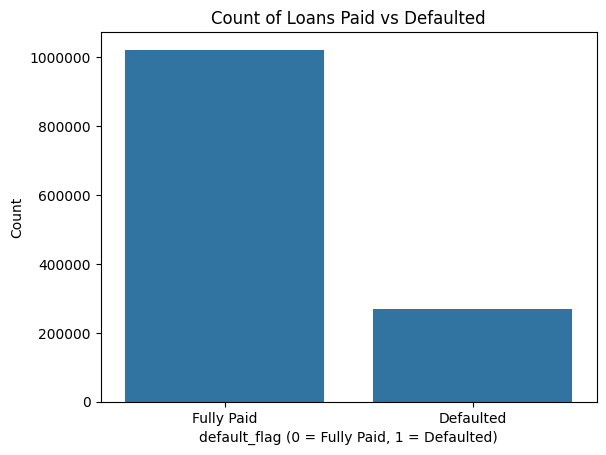

Number of fully paid loans: 1021321 (79.22%)
Number of defaulted loans: 267823 (20.78%)
Total number of loans give out: 1289144


In [34]:
sns.countplot(x='default_flag', data=df)
plt.title("Count of Loans Paid vs Defaulted")
plt.xlabel("default_flag (0 = Fully Paid, 1 = Defaulted)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Fully Paid', 'Defaulted'])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

print(f"Number of fully paid loans: {df['default_flag'].value_counts()[0]} ({df['default_flag'].value_counts()[0] / len(df) * 100:.2f}%)")
print(f"Number of defaulted loans: {df['default_flag'].value_counts()[1]} ({df['default_flag'].value_counts()[1] / len(df) * 100:.2f}%)")
print(f"Total number of loans give out: {len(df['default_flag'])}")

### Feature Distributions

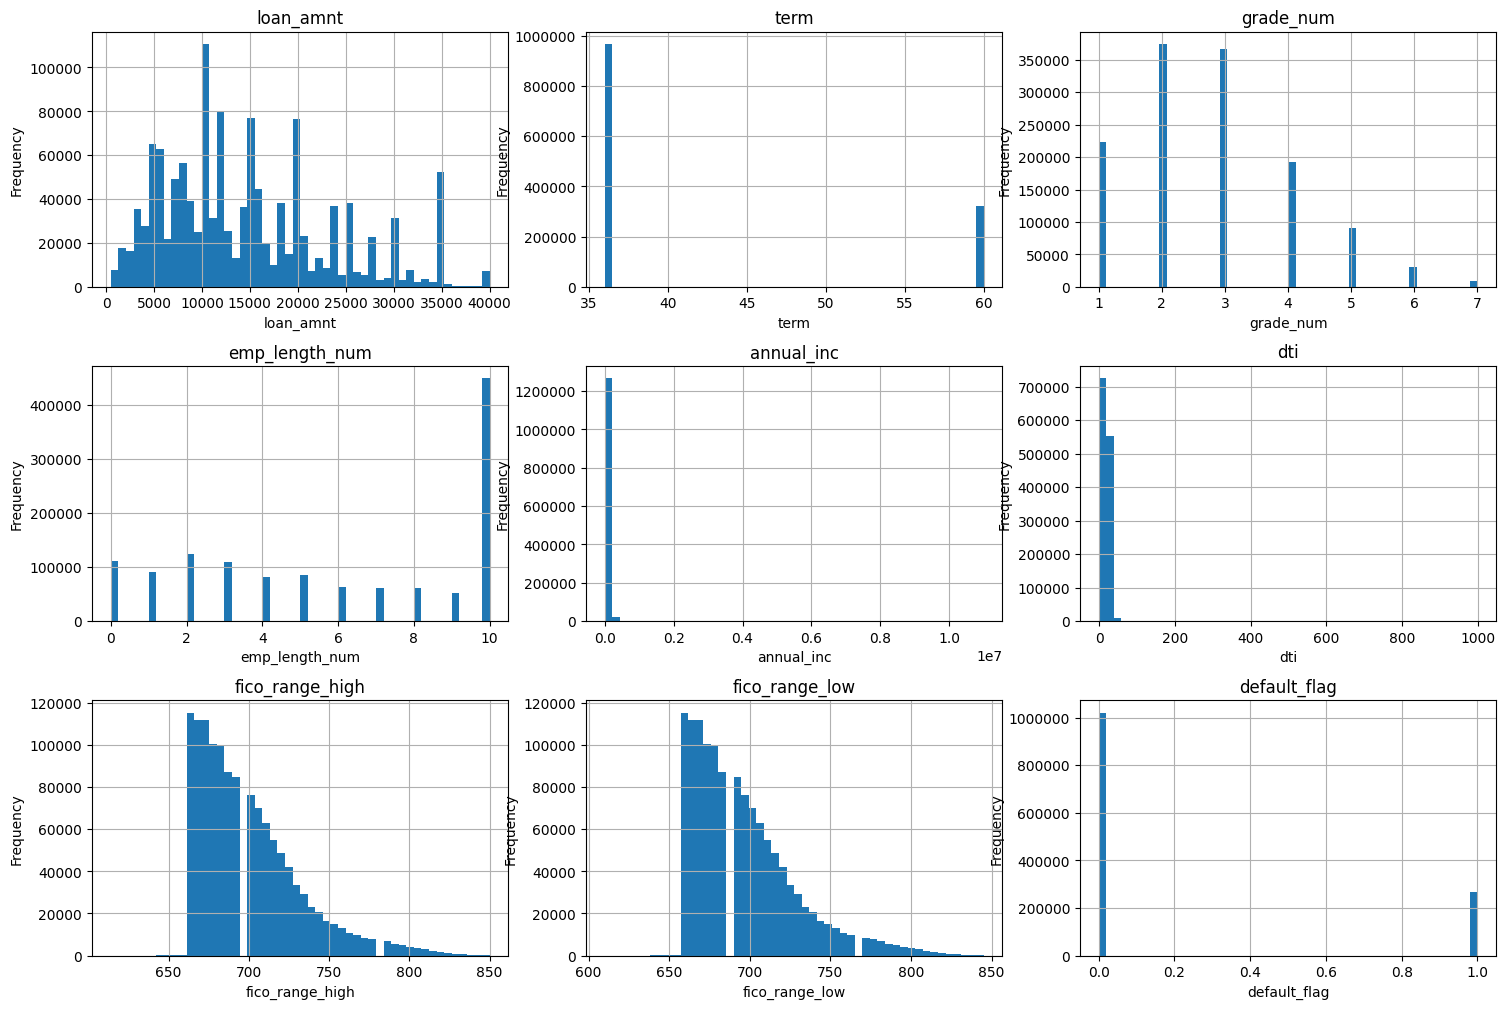

In [35]:
axes = df[key_columns].hist(bins=50, figsize=(15, 10))
plt.tight_layout()
for ax in axes.flatten():
    colname = ax.get_title()
    ax.set_xlabel(colname)
    ax.set_ylabel("Frequency")
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
plt.show()


### Correlation Analysis

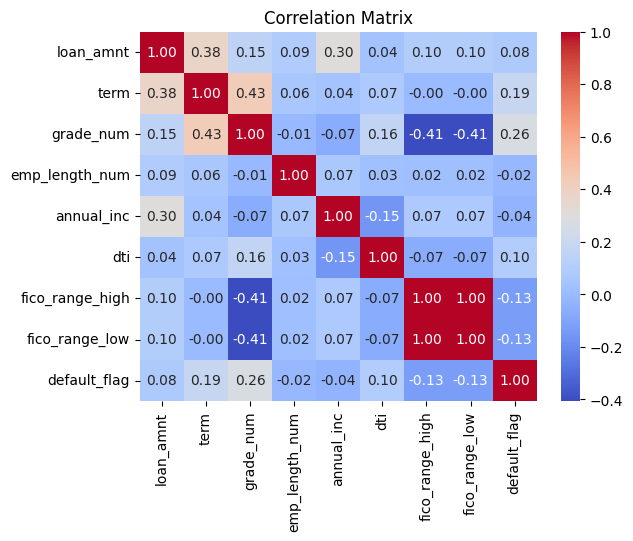

In [36]:
corr_matrix = df[key_columns].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#### Loan Amount vs. Term

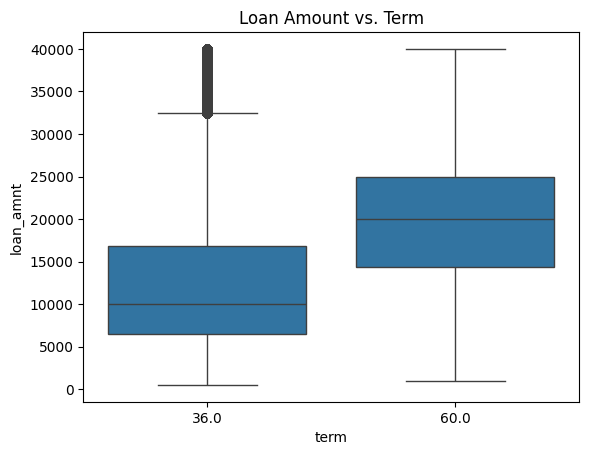

In [37]:
sns.boxplot(x='term', y='loan_amnt', data=df)
plt.title("Loan Amount vs. Term")
plt.show()

A **weak positive correlation of 0.38** exists between the loan amount and the loan term. 

This suggests that as the loan amount increases, the term of the loan tends to be slightly longer, though this relationship is not particularly strong.

#### Grade vs. FICO Score

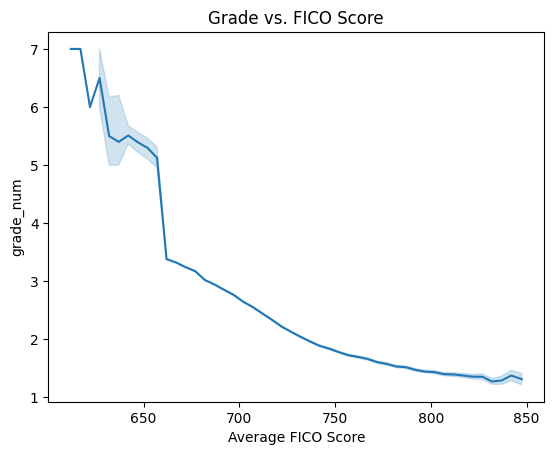

In [38]:
avg_fico_score = (df['fico_range_high'] + df['fico_range_low']) / 2
sns.lineplot(x=avg_fico_score, y='grade_num', data=df)
plt.title("Grade vs. FICO Score")
plt.xlabel("Average FICO Score")
plt.show()

There's a **moderate negative correlation** of -0.41 between the averaged FICO score and the grade_num. 

This means that as the FICO score increases, the loan grade_num tends to decrease. Since a lower grade_num corresponds to a better loan 'grade', this indicates that borrowers with higher FICO scores generally receive better loan 'grade'.

#### Grade vs. Term

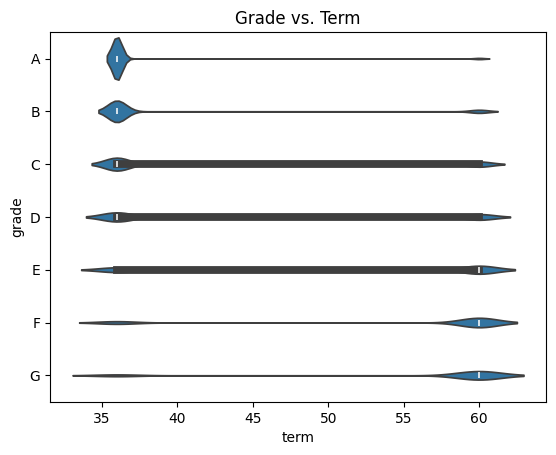

In [39]:
grade_order = sorted(df['grade'].unique())
sns.violinplot(x='term', y='grade', data=df, order=grade_order)
plt.title("Grade vs. Term")
plt.show()

There's a **moderate positive correlation of 0.42** between the loan term and the loan grade number (grade_num). 

This indicates that loans with better grades (lower grade_num) are more frequently associated with a shorter, 36 months term, while loans with worse grades (higher grade_num) are more likely to have a longer, 60 months term.



#### Default Flag vs. Grade

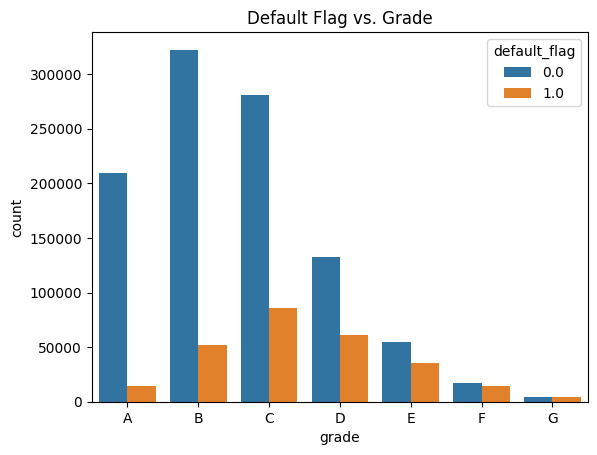

In [40]:
grade_order = sorted(df['grade'].unique())
sns.countplot(x='grade', hue='default_flag', data=df, order=grade_order)
plt.title("Default Flag vs. Grade")
plt.show()

There's a **weak positive correlation of 0.26** between the default_flag and grade_num. 

This indicates that as the loan grade improves (lower grade_num), the likelihood of a loan defaulting decreases.

## Modeling & Evaluation

### Model Training - Logistic Regression

The dataset was split into training and testing sets to prepare for logistic regression. The model was trained on 80% of the data, while the remaining 20% was reserved for evaluating its performance.

In [41]:
key_columns_no_default_flag = [col for col in key_columns if col != 'default_flag']

X = df[key_columns_no_default_flag]
y = df['default_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

joblib.dump(model, "loan_default_model.pkl")

['loan_default_model.pkl']

### Model Evaluation

#### ROC Curve & AUC Score

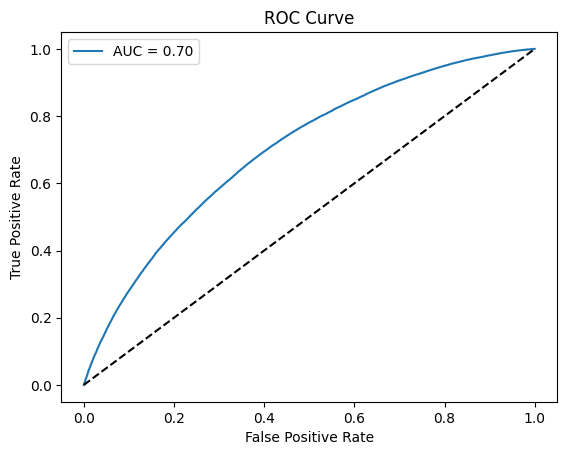

AUC Score: 0.7013251963482103
Model Score: 0.7922537806065261


In [42]:
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("AUC Score:", auc_score)
print("Model Score:", model.score(X_test, y_test))

#### Confusion Matrix

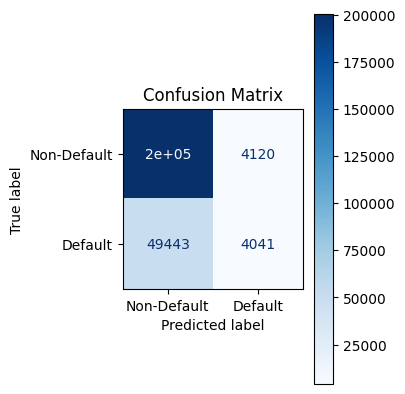

In [43]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Default', 'Default'])

plt.subplot(1, 2, 2)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

#### Feature Coefficients

In [44]:
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_[0]
})

# Add odds ratio (more intuitive than raw coefficients)
coef_df['odds_ratio'] = np.exp(coef_df['coefficient'])

# Sort by absolute effect
coef_df = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)

coef_df

,feature,coefficient,odds_ratio
2,grade_num,0.35,1.42
1,term,0.02,1.02
3,emp_length_num,-0.01,0.99
7,fico_range_low,-0.01,0.99
5,dti,0.01,1.01
6,fico_range_high,0.01,1.01
0,loan_amnt,0.00,1.00
4,annual_inc,-0.00,1.00


**Coefficient**
: a positive coefficient indicates that a feature's value increases the probability of default, while a negative coefficient means it decreases the probability of default. 

**Odds ratio**
: odds ratio greater than 1 means the odds of default increase by (Odds Ratio - 1) * 100% for each one-unit change in the feature. Conversely, an odds ratio less than 1 means the odds of default decrease by (1 - Odds Ratio) * 100% for each one-unit change.

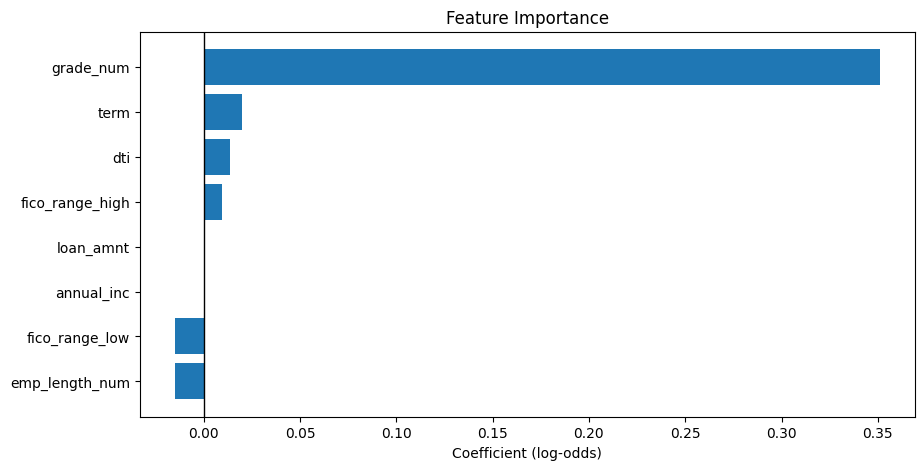

In [45]:
plt.figure(figsize=(10,5))
coef_df = coef_df.sort_values('coefficient')

plt.barh(coef_df['feature'], coef_df['coefficient'])
plt.axvline(0, color='black', linewidth=1)
plt.xlabel('Coefficient (log-odds)')
plt.title('Feature Importance')
plt.show()

## Demo

In [46]:
user_data = {
    'loan_amnt': [20000],
    'term': [36],
    'grade_num': [4],
    'emp_length_num': [0],
    'annual_inc': [0],
    'dti': [18.5],
    'fico_range_high': [600],
    'fico_range_low': [600]
}

df_user_data = pd.DataFrame(user_data)

prob_default = model.predict_proba(df_user_data)[:, 1][0]
print(f"Predicted default risk: {prob_default:.2%}")

Predicted default risk: 40.13%
